In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# I decided to add the following three blocks of code
# to better view the columns for each data table.
inspector = inspect(engine)

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

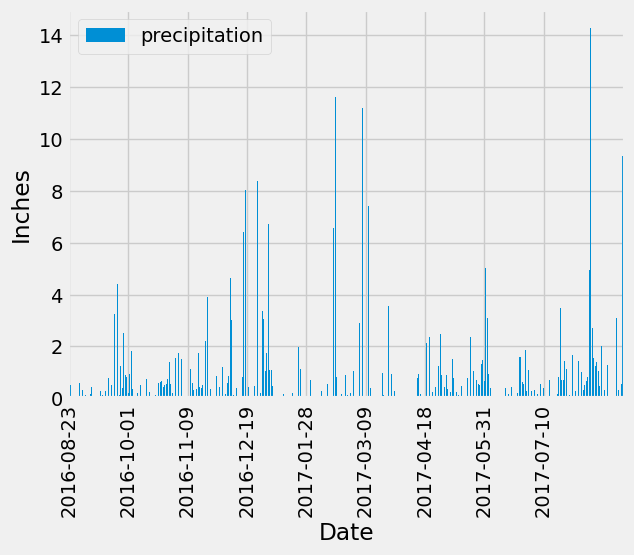

In [156]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
starting_date = '2013-08-23'

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= query_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.set_index('date', inplace=True)

df.plot.bar()



# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(12,6))
#plt.bar(total_rainfall.index, total_rainfall.values)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'])
tick_positions = [0, 39, 78, 117, 156, 195, 234, 273, 312]
tick_labels = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', 
               '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']

plt.xticks(tick_positions, tick_labels, rotation=90)
plt.show()

In [84]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [71]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [106]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
                



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

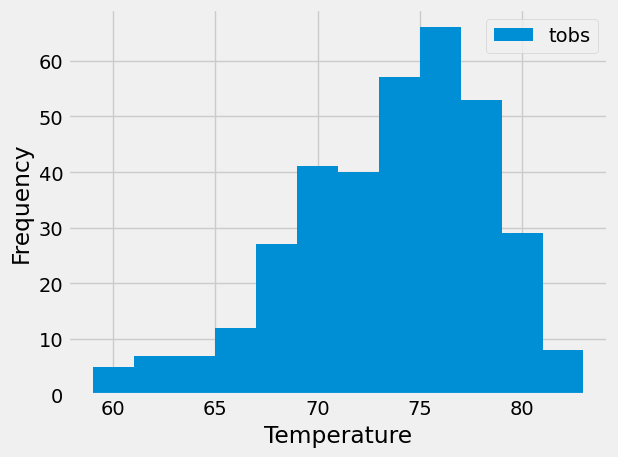

In [146]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).\
    group_by(Measurement.tobs).all()
    
x_values = [x for x, _ in station_temps]
y_values = [y for _, y in station_temps]

plt.hist(x_values, bins=12, weights=y_values, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()



# Close Session

In [147]:
# Close Session
session.close()